# 01- Preprocess & EDA

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sklearn as sk
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

In [3]:
import sys
sys.path.append('../')

import src

In [4]:
plt.style.use('fivethirtyeight')

## Load raw data

In [5]:
df = src.loader.load_raw()

In [6]:
df.head(1)

,type,date,operation,lat,long,sex,age,ethnicity_self,ethnicity_officer,legislation,search_target,outcome,found_target,stripped,station
observation_id,,,,,,,,,,,,,,,
d62c9e35-6293-45fc-aab6-706bdac1601e,Person search,2017-12-01 00:00:00+00:00,False,50.923411,-0.461108,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,False,False,sussex


In [22]:
df.iloc[0].to_dict()

{'type': 'Person search',
 'date': Timestamp('2017-12-01 00:00:00+0000', tz='UTC'),
 'operation': False,
 'lat': 50.923411,
 'long': -0.461108,
 'sex': 'Male',
 'age': '18-24',
 'ethnicity_self': 'White - English/Welsh/Scottish/Northern Irish/British',
 'ethnicity_officer': 'White',
 'legislation': 'Misuse of Drugs Act 1971 (section 23)',
 'search_target': 'Controlled drugs',
 'outcome': 'Offender given drugs possession warning',
 'found_target': False,
 'stripped': False,
 'station': 'sussex'}

In [8]:
df.found_target.unique()

array([False, True, nan], dtype=object)

In [12]:
df.operation.unique()

array([False, True, nan], dtype=object)

In [15]:
di = {'a': 1, 'b': 2}

In [20]:
di[['a', 'b']]

TypeError: unhashable type: 'list'

## Raw Data Profile

In [22]:
profile = pp.ProfileReport(df, title='Raw Data Profiling Report', explorative=False, minimal=False, pool_size=0, progress_bar=True)
profile.to_file('../reports/profiling/raw_profile.html')
#profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

PicklingError: Could not pickle the task to send it to the workers.

## Preprocess

### Fill missing

If there was a search and the outcome has not been written please consider it to be False.

In [97]:
df.found_target = df.found_target.fillna(False).astype(bool)

Fill 'Removal of more than just outer clothing' with False except when it’s just a vehicle search.

In [99]:
df.stripped[df.type!='Vehicle search'] = df.stripped[df.type!='Vehicle search'].fillna(False).astype(bool)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Define target

In [100]:
offense_list = [
               #'A no further action disposal',
               'Arrest',
               'Community resolution',
               'Summons / charged by post',
               'Khat or Cannabis warning',
               'Caution (simple or conditional)',
               'Penalty Notice for Disorder',
               #'Nothing found - no further action',
               'Offender given drugs possession warning',
               'Local resolution',
               'Suspect arrested',
               'Article found - Detailed outcome unavailable',
               'Offender cautioned',
               'Suspect summonsed to court',
               'Offender given penalty notice',
               'Suspected psychoactive substances seized - No further action',
               ]
df['offense'] = [outcome in offense_list for outcome in df.outcome]
df['success'] = df.offense & df.found_target

In [101]:
df.to_pickle('../data/training.pickle')

## EDA Plots
### Time Series Plot

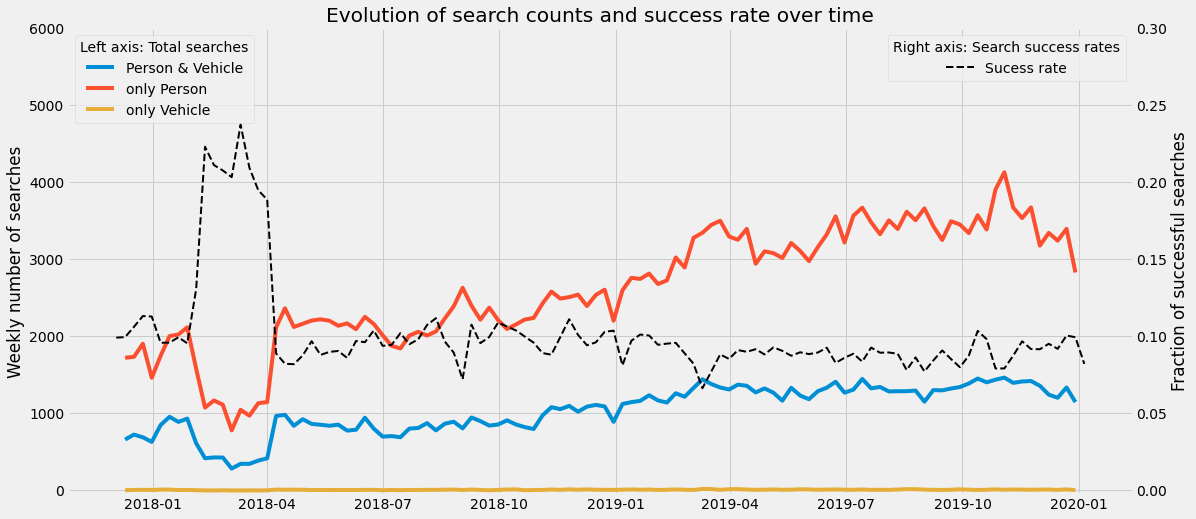

In [38]:
src.plots.make_countplot(df)

### Geographical Plot

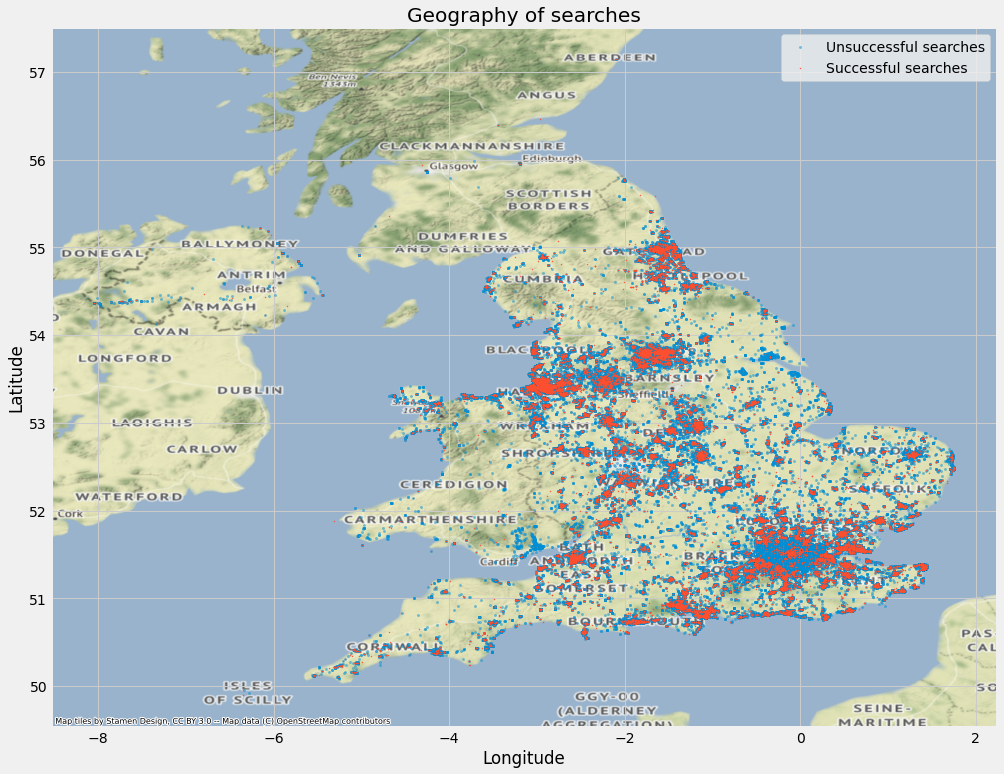

In [102]:
src.plots.make_geoplot(df)

### Does self defined ethnicity match officer ascribed ethnicity?

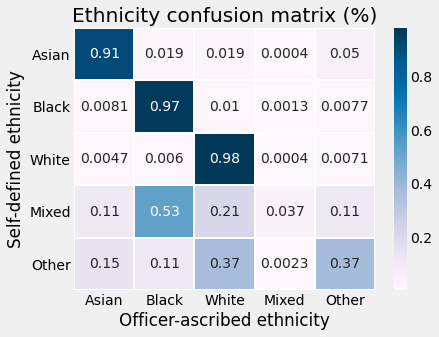

In [55]:
src.plots.make_confusion_heatmap(df)

In [74]:
len(df)

660611

### Analysis

In [85]:
group_counts = df.groupby(['ethnicity_officer', 'sex', 'station'])['success'].count().to_frame()
group_counts = group_counts[group_counts.reset_index().sex.values!='Other']
group_counts['few'] = group_counts<30

In [86]:
group_counts.few.sum()

179

In [90]:
df.groupby('sex').stripped.sum()

sex
Female    1307
Male      9346
Other       12
Name: stripped, dtype: int64